## Digital soil mapping of clay content

In this tutorial, my goal is to present an easy way to estimate clay content using digital soil mapping approaches. For this, a dataset with n samples with the clay content determined in the laboratory will be used as the target variable to be predicted over an area of n ha. As features, a median reflectance satellite image (Landsat) representing the bare surfaces will be used and a set of spectral indices calculated from Sentinel-2 mean reflectance images from the dry and moist seasons.

In [1]:
### Load libraries
import geopandas
import numpy as np
import pandas as pd
import folium
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
from rasterio.plot import show
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from shapely.geometry import Point
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from pprint import pprint

C:\Users\FREY\anaconda3\envs\gp_environ\lib\site-packages\pyproj\__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [2]:
### Load dataset
dat_clay = pd.read_csv('dataset.csv', sep=';')
dat_clay.head()

,X,Y,Clay.gkg,OM.gkg
0,-47.431591,-22.773409,301,22.21
1,-47.449435,-22.841908,503,25.02
2,-47.378210,-22.856072,120,15.00
3,-47.375972,-22.864430,128,8.00
4,-47.372973,-22.868192,117,11.00


In [3]:
### Basic statistics of the target variable
dat_clay.describe().T.style

,count,mean,std,min,25%,50%,75%,max
X,388.000000,-47.405859,0.028572,-47.457000,-47.429812,-47.402296,-47.384326,-47.345924
Y,388.000000,-22.865197,0.029960,-22.907360,-22.889000,-22.874463,-22.842459,-22.773409
Clay.gkg,388.000000,267.840206,161.258360,13.000000,124.000000,234.500000,418.500000,638.000000
OM.gkg,388.000000,18.600335,6.365130,5.800000,13.200000,17.900000,23.025000,39.000000


C:\Users\FREY\anaconda3\envs\gp_environ\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


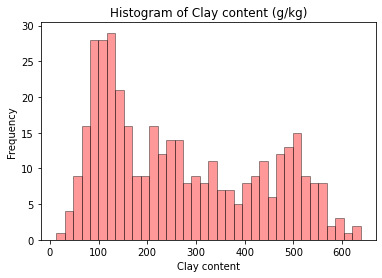

In [4]:
### Plotting histograms and density plots
sns.distplot(dat_clay['Clay.gkg'], hist = True, kde = False, bins = int(180/5), color = 'red', hist_kws = {'edgecolor': 'black'})
plt.title('Histogram of Clay content (g/kg)')
plt.xlabel('Clay content')
plt.ylabel('Frequency')
plt.show()

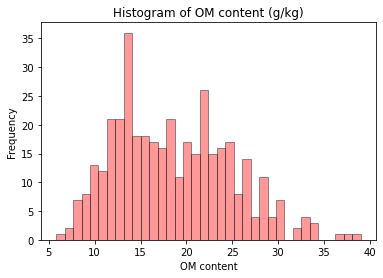

In [5]:
### Plotting histograms and density plot
sns.distplot(dat_clay['OM.gkg'], hist = True, kde = False, bins = int(180/5), color = 'red', hist_kws = {'edgecolor': 'black'})
plt.title('Histogram of OM content (g/kg)')
plt.xlabel('OM content')
plt.ylabel('Frequency')
plt.show()

In [6]:
## Convert pandas dataframe into geopandas
geo = [Point(xy) for xy in zip(dat_clay['X'], dat_clay['Y'])]
CRS = {'init': 'epsg:4326'}
dat_clay_gpd = geopandas.GeoDataFrame(dat_clay, crs=CRS, geometry=geo)
dat_clay_gpd.head()

C:\Users\FREY\anaconda3\envs\gp_environ\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,X,Y,Clay.gkg,OM.gkg,geometry
0,-47.431591,-22.773409,301,22.21,POINT (-47.43159 -22.77341)
1,-47.449435,-22.841908,503,25.02,POINT (-47.44944 -22.84191)
2,-47.378210,-22.856072,120,15.00,POINT (-47.37821 -22.85607)
3,-47.375972,-22.864430,128,8.00,POINT (-47.37597 -22.86443)
4,-47.372973,-22.868192,117,11.00,POINT (-47.37297 -22.86819)


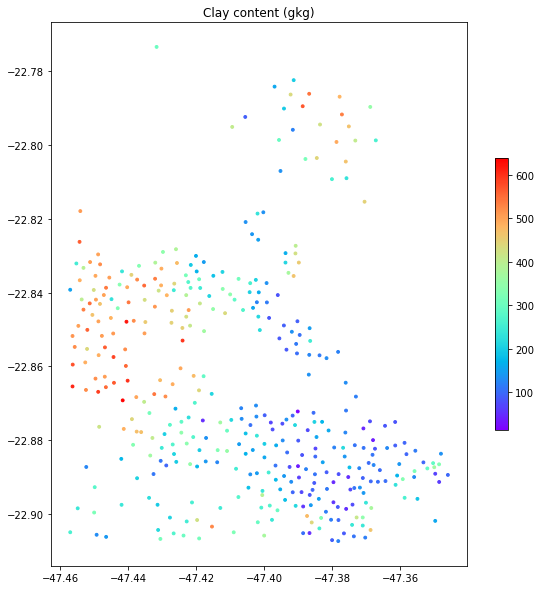

In [7]:
fig, ax = plt.subplots(figsize = (10,10))
dat_clay_gpd.plot(column= 'Clay.gkg', ax = ax, marker='o', markersize = 8, cmap = 'rainbow', legend=True, legend_kwds = {'shrink': 0.5})
ax.set_title('Clay content (gkg)')
plt.show()

In [8]:
## Plot in an interative base map to know where the 
coords = [-22.84, -47.4]
my_map = folium.Map(location = coords, zoom_start = 12)
folium.GeoJson(data=dat_clay_gpd["geometry"]).add_to(my_map)
my_map

<AxesSubplot:>

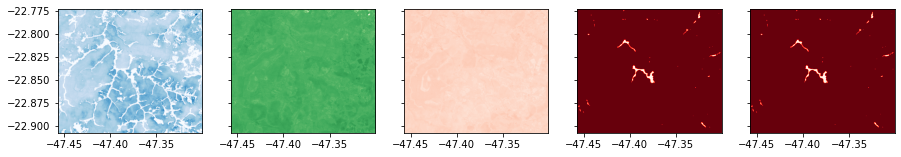

In [8]:
## Load rasters
covs = rasterio.open('covs_right.tif')

## Initialize subplots
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, nrows=1, figsize=(15,6), sharey = True)

## Polot bands
show((covs, 1), cmap = 'Blues', ax=ax1)
show((covs, 2), cmap = 'Greens', ax=ax2)
show((covs, 3), cmap = 'Reds', ax=ax3)
show((covs, 4), cmap = 'Reds', ax=ax4)
show((covs, 5), cmap = 'Reds', ax=ax5)

(16, 500, 581)


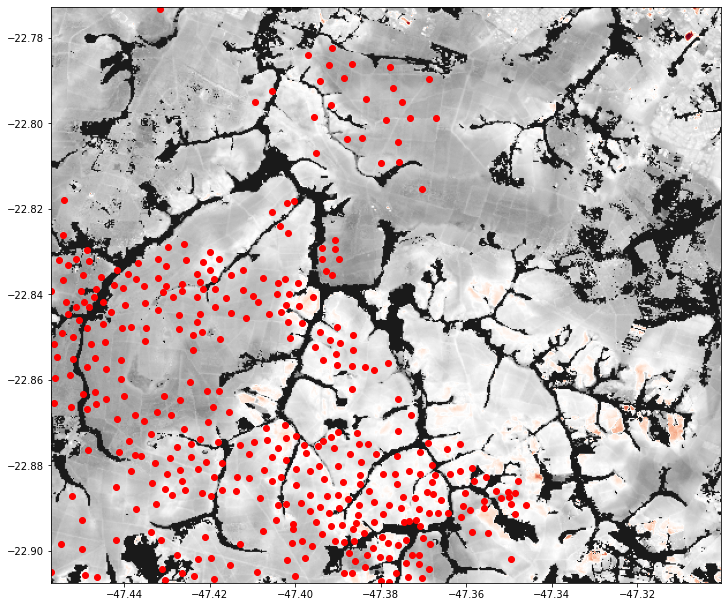

In [9]:
## RGB composite
#Read he grid values into numpy arrays
covs_arr = covs.read()
print(covs_arr.shape)
fig, ax = plt.subplots(figsize=(12,12))
dat_clay_gpd.plot(ax=ax, color='red')
show(covs, ax=ax, cmap = 'RdGy_r')
plt.show()

In [10]:
## Extract the raster values
dat_clay_gpd.index = range(len(dat_clay_gpd))
dat_clay_gpd
coords = [(x,y) for x, y in zip(dat_clay_gpd.X, dat_clay_gpd.Y)]
dat_clay_gpd['ju'] = [x for x in covs.sample(coords)]
dat_clay_gpd

,X,Y,Clay.gkg,OM.gkg,geometry,ju
0,-47.431591,-22.773409,301,22.21,POINT (-47.43159 -22.77341),"[0.04847401, -0.02138032, -0.007287594, 552.76..."
1,-47.449435,-22.841908,503,25.02,POINT (-47.44944 -22.84191),"[-1.0323621, -0.070158444, 0.2842601, 589.1586..."
2,-47.378210,-22.856072,120,15.00,POINT (-47.37821 -22.85607),"[1.5328755, 0.1327821, -0.11650907, 568.1477, ..."
3,-47.375972,-22.864430,128,8.00,POINT (-47.37597 -22.86443),"[2.1881053, 0.13289563, 0.0023012678, 583.1302..."
4,-47.372973,-22.868192,117,11.00,POINT (-47.37297 -22.86819),"[2.3716109, -0.037705604, -0.21357366, 574.915..."
...,...,...,...,...,...,...
383,-47.385720,-22.893479,94,13.20,POINT (-47.38572 -22.89348),"[4.755094, -0.42863974, -0.1972487, 634.4948, ..."
384,-47.379980,-22.907101,91,12.00,POINT (-47.37998 -22.90710),"[3.1949377, -0.07870719, -0.24304345, 539.6522..."
385,-47.378296,-22.898116,86,11.00,POINT (-47.37830 -22.89812),"[3.0646853, -0.24409293, -0.3677843, 613.9363,..."
386,-47.409350,-22.795095,404,27.00,POINT (-47.40935 -22.79509),"[0.52588475, -0.17827126, -0.045844372, 553.08..."


In [11]:
## Convert to pandas dataframe and separate the columns list
dat_clay_df = pd.DataFrame(dat_clay_gpd)
dat_split = pd.DataFrame(dat_clay_df['ju'].tolist(), columns = ['PC1', 'PC2', 'PC3', "Elevation",\
                                                               "Slope", "Aspect", "Hillshade", "Northness", "Eastness", "HorizontalCurvature",\
                                                                "VerticalCurvature", "MeanCurvature", "GaussianCurvature", "MinimalCurvature",\
                                                                "MaximalCurvature", "ShapeIndex"])
dat_clay_df = pd.concat([dat_clay_df, dat_split], axis=1)
dat_clay_df = dat_clay_df.drop(['geometry', 'ju', 'X', 'Y'], axis=1)  ## drop all the columns that will no be used
dat_clay_df.to_csv('data_clay_with_features.csv')  ## Save